Э
В этом задании Вам предстоит обучить языковую модель с помощью рекуррентной нейронной сети. В отличие от семинарского занятия, Вам необходимо будет работать с отдельными словами, а не буквами.


Установим модуль ```datasets```, чтобы нам проще было работать с данными.

In [1]:
!pip install datasets

INFO: pip is looking at multiple versions of multiprocess to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 471.6/471.6 kB 10.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 7.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 8.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 13.7 MB/s eta 0:00:00


Импорт необходимых библиотек

In [2]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

import numpy as np
import matplotlib.pyplot as plt

from tqdm.auto import tqdm
from datasets import load_dataset
from nltk.tokenize import sent_tokenize, word_tokenize
from sklearn.model_selection import train_test_split
import nltk

from collections import Counter
from typing import List

import seaborn
seaborn.set(palette='summer')

In [3]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [4]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

## Подготовка данных

Воспользуемся датасетом imdb. В нем хранятся отзывы о фильмах с сайта imdb. Загрузим данные с помощью функции ```load_dataset```

In [5]:
# Загрузим датасет
dataset = load_dataset('imdb')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/7.81k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/21.0M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/20.5M [00:00<?, ?B/s]

unsupervised-00000-of-00001.parquet:   0%|          | 0.00/42.0M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating unsupervised split:   0%|          | 0/50000 [00:00<?, ? examples/s]

In [6]:
dataset['test']['text'][0]

'I love sci-fi and am willing to put up with a lot. Sci-fi movies/TV are usually underfunded, under-appreciated and misunderstood. I tried to like this, I really did, but it is to good TV sci-fi as Babylon 5 is to Star Trek (the original). Silly prosthetics, cheap cardboard sets, stilted dialogues, CG that doesn\'t match the background, and painfully one-dimensional characters cannot be overcome with a \'sci-fi\' setting. (I\'m sure there are those of you out there who think Babylon 5 is good sci-fi TV. It\'s not. It\'s clichéd and uninspiring.) While US viewers might like emotion and character development, sci-fi is a genre that does not take itself seriously (cf. Star Trek). It may treat important issues, yet not as a serious philosophy. It\'s really difficult to care about the characters here as they are not simply foolish, just missing a spark of life. Their actions and reactions are wooden and predictable, often painful to watch. The makers of Earth KNOW it\'s rubbish as they have

### Препроцессинг данных и создание словаря (1 балл)

Далее вам необходмо самостоятельно произвести препроцессинг данных и получить словарь или же просто ```set``` строк. Что необходимо сделать:

1. Разделить отдельные тренировочные примеры на отдельные предложения с помощью функции ```sent_tokenize``` из бибилиотеки ```nltk```. Каждое отдельное предложение будет одним тренировочным примером.
2. Оставить только те предложения, в которых меньше ```word_threshold``` слов.
3. Посчитать частоту вхождения каждого слова в оставшихся предложениях. Для деления предлоения на отдельные слова удобно использовать функцию ```word_tokenize```.
4. Создать объект ```vocab``` класса ```set```, положить в него служебные токены '\<unk\>', '\<bos\>', '\<eos\>', '\<pad\>' и vocab_size самых частовстречающихся слов.   

In [7]:
sentences = []

def update_corpus(dataset, dir, word_threshold = 32):
  '''
  Дополняет корпус слов
  dataset: набор данных
  dir: директория набора данных
  word_threshold : порог количества слов в предложении
  '''
  for sentence in tqdm(dataset[dir]['text']):
      sentences.extend(
          [x.lower() for x in sent_tokenize(sentence, language='english') if len(x.split()) < word_threshold])
  return sentences

In [8]:
#тренировочный сабсет
tr_sentences = update_corpus(dataset, 'train')

  0%|          | 0/25000 [00:00<?, ?it/s]

In [9]:
len(tr_sentences)

219930

In [10]:
# весь корпус предложений
for el in ['unsupervised', 'test']:
  update_corpus(dataset, el)

  0%|          | 0/50000 [00:00<?, ?it/s]

  0%|          | 0/25000 [00:00<?, ?it/s]

In [11]:
print("Всего предложений:", len(sentences))

Всего предложений: 870929


Посчитаем для каждого слова его встречаемость.

In [12]:
words = Counter()

for sentence in tqdm(sentences):
    for word in word_tokenize(sentence):
        words[word] += 1

  0%|          | 0/870929 [00:00<?, ?it/s]

Добавим в словарь ```vocab_size``` самых встречающихся слов.

In [13]:
vocab = set()

vocab = set(['<unk>', '<bos>', '<eos>', '<pad>'])
vocab_size = 40000

# отсортируем 40000 самых часто встречающихся слов
commonWords = words.most_common(vocab_size)
# добавим слова в словарь
for i in range(0, vocab_size):
  vocab.add(commonWords[i][0])

In [14]:
assert '<unk>' in vocab
assert '<bos>' in vocab
assert '<eos>' in vocab
assert '<pad>' in vocab
assert len(vocab) == vocab_size + 4

In [15]:
print("Всего слов в словаре:", len(vocab))

Всего слов в словаре: 40004


### Подготовка датасета (1 балл)

Далее, как и в семинарском занятии, подготовим датасеты и даталоадеры.

В классе ```WordDataset``` вам необходимо реализовать метод ```__getitem__```, который будет возвращать сэмпл данных по входному idx, то есть список целых чисел (индексов слов).

Внутри этого метода необходимо добавить служебные токены начала и конца последовательности, а также токенизировать соответствующее предложение с помощью ```word_tokenize``` и сопоставить ему индексы из ```word2ind```.

In [16]:
word2ind = {word: i for i, word in enumerate(vocab)}
ind2word = {i: word for word, i in word2ind.items()}

In [17]:
class WordDataset:
    def __init__(self, sentences):
        self.data = sentences
        self.unk_id = word2ind['<unk>']
        self.bos_id = word2ind['<bos>']
        self.eos_id = word2ind['<eos>']
        self.pad_id = word2ind['<pad>']

    def __getitem__(self, idx: int) -> List[int]:
        tokenized_sentence = [self.bos_id]
        tokenized_sentence += [word2ind.get(word, self.unk_id) for word in word_tokenize(self.data[idx])]
        tokenized_sentence += [self.eos_id]

        return tokenized_sentence


    def __len__(self) -> int:
        return len(self.data)

In [18]:
def collate_fn_with_padding(
    input_batch: List[List[int]], pad_id=word2ind['<pad>']) -> torch.Tensor:
    seq_lens = [len(x) for x in input_batch]
    max_seq_len = max(seq_lens)

    new_batch = []
    for sequence in input_batch:
        for _ in range(max_seq_len - len(sequence)):
            sequence.append(pad_id)
        new_batch.append(sequence)

    sequences = torch.LongTensor(new_batch).to(device)

    new_batch = {
        'input_ids': sequences[:,:-1],
        'target_ids': sequences[:,1:]
    }

    return new_batch

In [19]:
train_sentences, eval_sentences = train_test_split(tr_sentences, test_size=0.2)
eval_sentences, test_sentences = train_test_split(tr_sentences, test_size=0.5)

train_dataset = WordDataset(train_sentences)
eval_dataset = WordDataset(eval_sentences)
test_dataset = WordDataset(test_sentences)

batch_size = 32

train_dataloader = DataLoader(
    train_dataset, collate_fn=collate_fn_with_padding, batch_size=batch_size)

eval_dataloader = DataLoader(
    eval_dataset, collate_fn=collate_fn_with_padding, batch_size=batch_size)

test_dataloader = DataLoader(
    test_dataset, collate_fn=collate_fn_with_padding, batch_size=batch_size)

## Обучение и архитектура модели

Вам необходимо на практике проверить, что влияет на качество языковых моделей. В этом задании нужно провести серию экспериментов с различными вариантами языковых моделей и сравнить различия в конечной перплексии на тестовом множестве.

Возмоэные идеи для экспериментов:

* Различные RNN-блоки, например, LSTM или GRU. Также можно добавить сразу несколько RNN блоков друг над другом с помощью аргумента num_layers. Вам поможет официальная документация [здесь](https://pytorch.org/docs/stable/generated/torch.nn.LSTM.html)
* Различные размеры скрытого состояния. Различное количество линейных слоев после RNN-блока. Различные функции активации.
* Добавление нормализаций в виде Dropout, BatchNorm или LayerNorm
* Различные аргументы для оптимизации, например, подбор оптимального learning rate или тип алгоритма оптимизации SGD, Adam, RMSProp и другие
* Любые другие идеи и подходы

После проведения экспериментов необходимо составить таблицу результатов, в которой описан каждый эксперимент и посчитана перплексия на тестовом множестве.

Учтите, что эксперименты, которые различаются, например, только размером скрытого состояния или количеством линейных слоев считаются, как один эксперимент.

Успехов!

### Функция evaluate (1 балл)

Заполните функцию ```evaluate```

In [20]:
def evaluate(model, criterion, dataloader = eval_dataloader) -> float:
    model.eval()
    perplexity = []
    with torch.no_grad():
        for batch in dataloader:
            logits =  model(batch['input_ids']).flatten(start_dim=0, end_dim=1)
            loss = criterion(logits, batch['target_ids'].flatten())
            perplexity.append(torch.exp(loss).item())

    perplexity = sum(perplexity) / len(perplexity)

    return perplexity

### Train loop (1 балл)

Напишите функцию для обучения модели.

In [21]:
def train_model(model, num_epoch):
  losses = []
  perplexities = []
  criterion = nn.CrossEntropyLoss(ignore_index=word2ind['<pad>'])
  optimizer = torch.optim.Adam(model.parameters())

  for epoch in range(num_epoch):
      epoch_losses = []
      model.train()
      for batch in tqdm(train_dataloader, desc=f'Training epoch {epoch}:'):
          optimizer.zero_grad()
          logits = model(batch['input_ids']).flatten(start_dim=0, end_dim=1)
          loss = criterion(
              logits, batch['target_ids'].flatten())
          loss.backward()
          optimizer.step()

          epoch_losses.append(loss.item())

      losses.append(sum(epoch_losses) / len(epoch_losses))
      perplexities.append(evaluate(model, criterion))
  return losses, perplexities

### Первый эксперимент (2 балла)

Определите архитектуру модели и обучите её.

In [ ]:
class LanguageModel(nn.Module):
    def __init__(self, hidden_dim: int, vocab_size: int, num_layers: int, dropout_rate: float):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, hidden_dim)
        self.gru = nn.GRU(hidden_dim, hidden_dim, num_layers = num_layers, batch_first=True)
        self.linear = nn.Linear(hidden_dim, hidden_dim)
        self.projection = nn.Linear(hidden_dim, vocab_size)
        self.non_lin = nn.Tanh()
        self.dropout = nn.Dropout(p=dropout_rate)

    def forward(self, input_batch: torch.Tensor) -> torch.Tensor:
        embeddings = self.embedding(input_batch)  # [batch_size, seq_len, hidden_dim]
        output, _ = self.gru(embeddings)  # [batch_size, seq_len, hidden_dim]
        output = self.dropout(self.linear(self.non_lin(output)))  # [batch_size, seq_len, hidden_dim]
        projection = self.projection(self.non_lin(output))  # [batch_size, seq_len, vocab_size]

        return projection

In [ ]:
import gc
gc.collect()
torch.cuda.empty_cache()

In [ ]:
model = LanguageModel(hidden_dim=256, vocab_size=len(vocab), num_layers = 1, dropout_rate = 0.1).to(device)
losses, perplexities = train_model(model, num_epoch = 5)

Training epoch 0::   0%|          | 0/21774 [00:00<?, ?it/s]

Training epoch 1::   0%|          | 0/21774 [00:00<?, ?it/s]

Training epoch 2::   0%|          | 0/21774 [00:00<?, ?it/s]

Training epoch 3::   0%|          | 0/21774 [00:00<?, ?it/s]

Training epoch 4::   0%|          | 0/21774 [00:00<?, ?it/s]

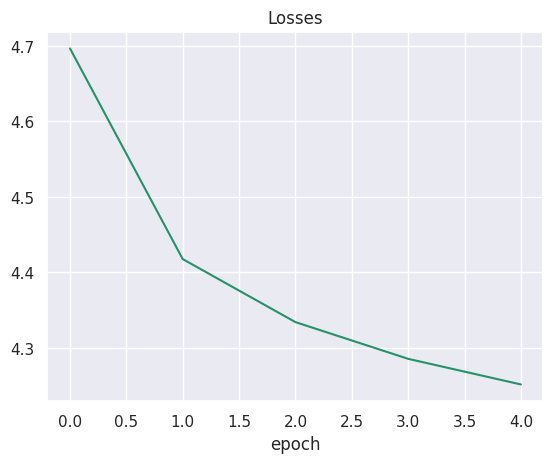

In [ ]:
plt.plot(np.arange(len(losses)), losses)
plt.title('Losses')
plt.xlabel("epoch")
plt.show()

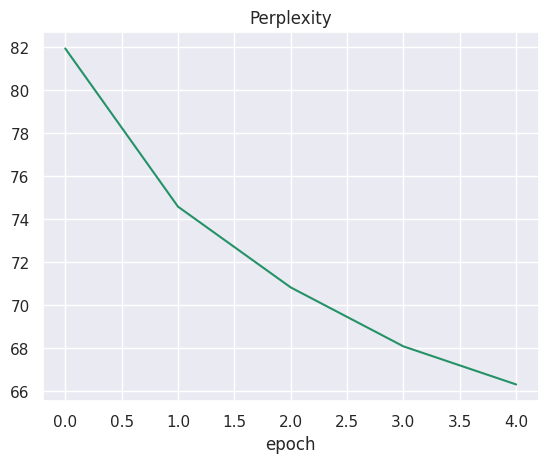

In [ ]:
plt.plot(np.arange(len(perplexities)), perplexities)
plt.title('Perplexity')
plt.xlabel("epoch")
plt.show()

In [25]:
def display_stats(losses, perplexities, name):
  '''
  print stats plots and best perplexity
  '''

  plt.subplots(figsize=(15, 5))

  plt.subplot(1, 2, 1)
  plt.plot(np.arange(len(losses)), losses, 'g')
  plt.title('Losses ' + name)
  plt.xlabel("epoch")

  plt.subplot(1, 2, 2)
  plt.plot(np.arange(len(perplexities)), perplexities, 'r')
  plt.title('Perplexity ' + name)
  plt.xlabel("epoch")

  plt.show()

  print('Best perplexity', round(min(perplexities),3))

### Второй эксперимент (2 балла)

Попробуйте что-то поменять в модели или в пайплайне обучения, идеи для экспериментов можно подсмотреть выше.

Применим LSTM c теми же гиперпараметрами и выберем модель для дальнейших экспериментов

In [29]:
class LSTMModel(nn.Module):
    def __init__(self, hidden_dim: int, vocab_size: int, num_layers: int, dropout_rate: float):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, hidden_dim)
        self.LSTM = nn.LSTM(hidden_dim, hidden_dim, num_layers = num_layers, batch_first=True)
        self.linear = nn.Linear(hidden_dim, hidden_dim)
        self.projection = nn.Linear(hidden_dim, vocab_size)
        self.non_lin = nn.Tanh()
        self.dropout = nn.Dropout(p=dropout_rate)

    def forward(self, input_batch: torch.Tensor) -> torch.Tensor:
        embeddings = self.embedding(input_batch)  # [batch_size, seq_len, hidden_dim]
        output, _ = self.LSTM(embeddings)  # [batch_size, seq_len, hidden_dim]
        output = self.dropout(self.linear(self.non_lin(output)))  # [batch_size, seq_len, hidden_dim]
        projection = self.projection(self.non_lin(output))  # [batch_size, seq_len, vocab_size]

        return projection

In [ ]:
LSTM_model = LSTMModel(hidden_dim=256, vocab_size=len(vocab), num_layers = 1, dropout_rate = 0.1).to(device)
LSTMlosses, LSTMperplexities = train_model(LSTM_model, num_epoch = 5)

Training epoch 0::   0%|          | 0/21774 [00:00<?, ?it/s]

Training epoch 1::   0%|          | 0/21774 [00:00<?, ?it/s]

Training epoch 2::   0%|          | 0/21774 [00:00<?, ?it/s]

Training epoch 3::   0%|          | 0/21774 [00:00<?, ?it/s]

Training epoch 4::   0%|          | 0/21774 [00:00<?, ?it/s]

<ipython-input-44-188044e11d39>:4: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1, 2, 1)


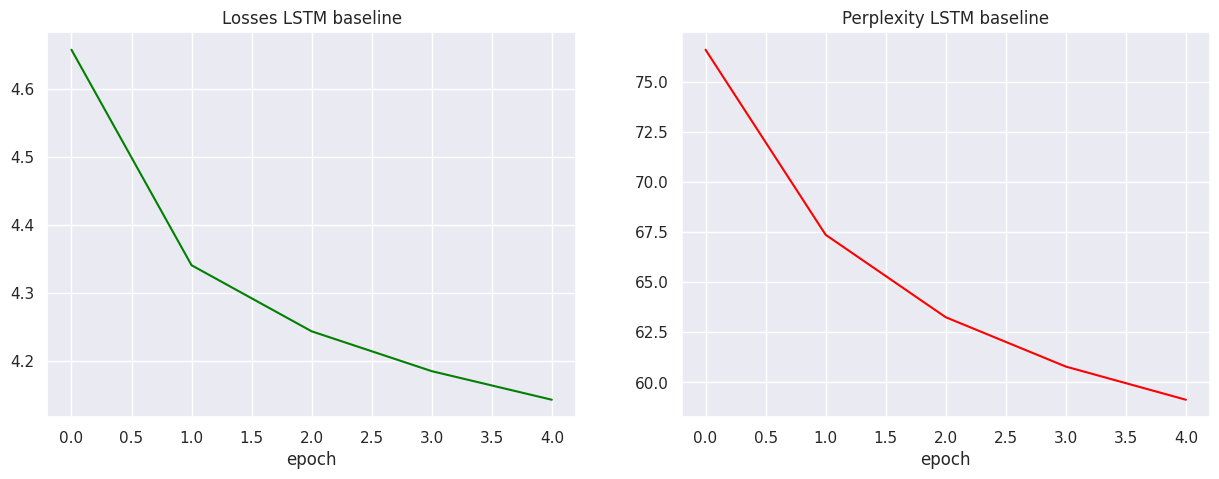

Best perplexity 59.137


In [ ]:
display_stats(LSTMlosses, LSTMperplexities, 'LSTM baseline')

Так как перплексия ниже у LSTM модели, будем проводить эксперименты на ней. Увеличим количество слоёв для LSTM.

In [23]:
LSTM_3l_model = LSTMModel(hidden_dim=256, vocab_size=len(vocab), num_layers = 3, dropout_rate = 0.1).to(device)
LSTM_3llosses, LSTM_3lperplexities = train_model(LSTM_3l_model, num_epoch = 5)

Training epoch 0::   0%|          | 0/21774 [00:00<?, ?it/s]

Training epoch 1::   0%|          | 0/21774 [00:00<?, ?it/s]

Training epoch 2::   0%|          | 0/21774 [00:00<?, ?it/s]

Training epoch 3::   0%|          | 0/21774 [00:00<?, ?it/s]

Training epoch 4::   0%|          | 0/21774 [00:00<?, ?it/s]

<ipython-input-25-188044e11d39>:4: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1, 2, 1)


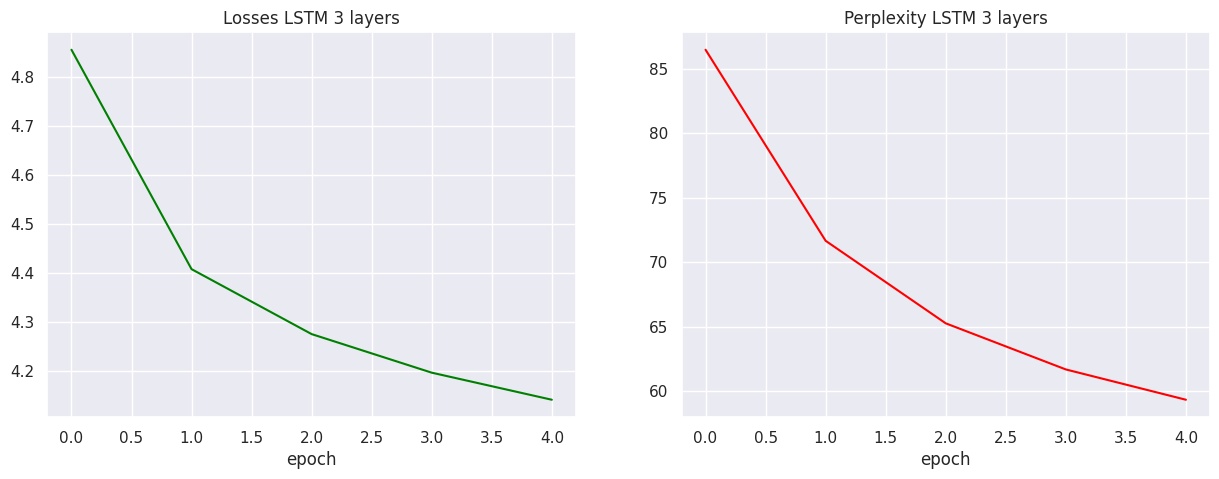

Best perplexity 59.323


In [26]:
display_stats(LSTM_3llosses, LSTM_3lperplexities, 'LSTM 3 layers')

С увеличением num_layers метрика не уменьшается

### Отчет (2 балла)

Опишите проведенные эксперименты. Сравните перплексии полученных моделей. Предложите идеи по улучшению качества моделей.

Для отбора самых часто встречающихся слов были использованы все 3 набора данных. Обучение проводилось только на train датасете из-за ограничений вычислительных ресурсов.

Проведены эксперименты: обучение модели на основе GRU, обучение модели на основе LSTM, получено стабильное уменьшение loss и perplexity на 5 эпохах. Перплексия оказалась ниже для модели LSTM при одинаковых гиперпараметрах. Увеличение num_layers не лучшает качество.

Использование всех трёх датасетов в обучении могло бы улучшить качество модели.
Также можно было бы изменить подход к паддингу, увеличить количество эпох обучения, проанализировать влияние предобработки текста (например, обработать аббревиатуры, представить числа как текст, предобработать пунктуацию).